In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import seaborn as sns


%matplotlib inline

import matplotlib
%config InlineBackend.figure_format='retina'

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

# turn off warnings
import warnings
warnings.filterwarnings('ignore')
# turn off future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders

from collections import Counter


In [2]:
# import pkl file with data
with open('./2023_data.pkl', 'rb') as f:
    data = pd.read_pickle(f)

In [3]:
data

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,n_springer_nature,n_wiley,n_sage,n_elsevier,n_is_retracted,n_is_oa,n_is_oa_gold
0,Aalborg University,04m5j1k67,Denmark,2023,4655,journal-article,3315,167,278,160,73,217,77,895,0,2190,905
1,Aalto University,020hwjq30,Finland,2023,3380,journal-article,2492,127,145,66,92,179,48,634,0,2015,637
2,Aarhus University,01aj84f44,Denmark,2023,8184,journal-article,6619,251,298,256,314,834,166,1728,1,4672,1926
3,"Academic Center for Education, Culture and Res...",0126z4b94,Iran,2023,826,journal-article,752,70,20,17,48,39,12,177,0,366,244
4,Academy of Scientific and Innovative Research,053rcsq61,India,2023,3918,journal-article,3393,107,81,124,78,382,19,1278,0,816,488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,Çukurova University,05wxkj555,Turkey,2023,2062,journal-article,1872,190,78,58,15,71,19,225,1,1343,596
1407,Örebro University,05kytsw45,Sweden,2023,1353,journal-article,1157,115,50,93,41,96,54,260,0,972,397
1408,İnönü University,04asck240,Turkey,2023,1486,journal-article,1346,159,46,43,13,50,17,158,0,975,429
1409,İstanbul University Cerrahpaşa,01dzn5f42,Turkey,2023,2369,journal-article,2074,180,86,73,37,134,37,371,0,1274,589


In [4]:
# find rows where sum of 'n_taylor_francis', 'n_springer_nature', 'n_wiley', 'n_elsevier', 'n_sage' is zero
# these rows are not useful for analysis
data['sum'] = data['n_taylor_francis'] + data['n_springer_nature'] + data['n_wiley'] + data['n_elsevier'] + data['n_sage']
data[data['sum'] == 0]
# drop these rows
data = data[data['sum'] != 0]


In [5]:
# add mdpi ratio column 'mdpi_5' as a ratio of 'n_mdpi' to sum of 'n_taylor_francis', 'n_springer_nature', 'n_wiley', 'n_elsevier', 'n_sage'
data['mdpi_5'] = data['n_mdpi'] / (data['n_taylor_francis'] + data['n_springer_nature'] + data['n_wiley'] + data['n_elsevier'] + data['n_sage'])

In [6]:
# sort by 'mdpi_5' column
data = data.sort_values(by='mdpi_5', ascending=False)

<Axes: xlabel='mdpi_5', ylabel='Count'>

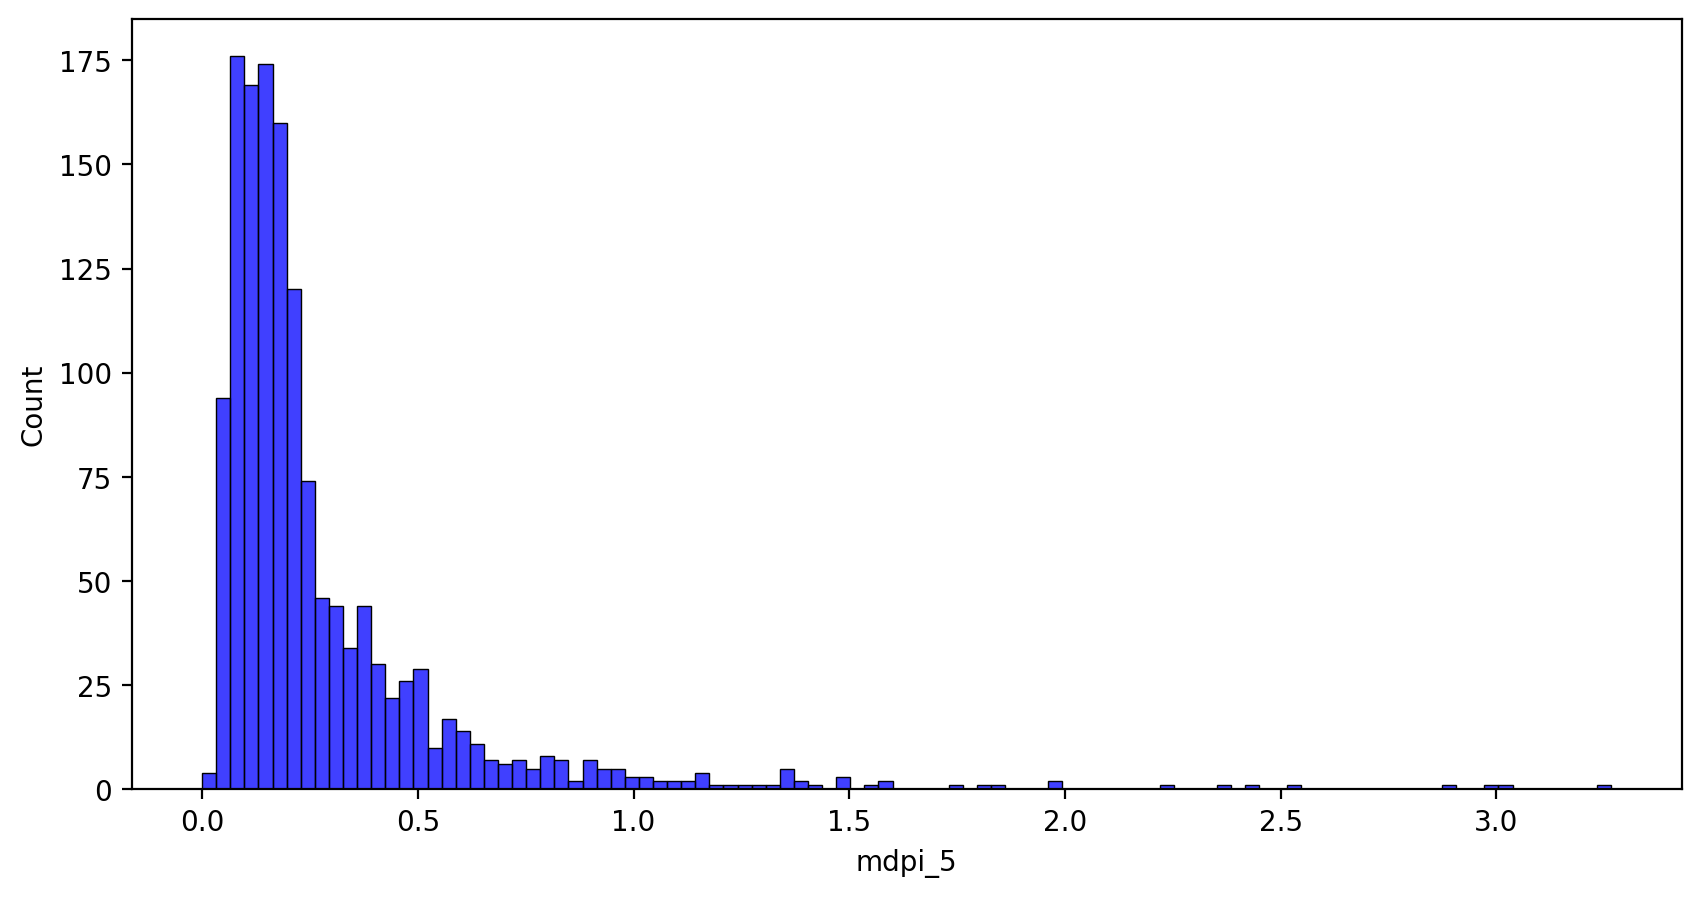

In [7]:
# plot 'mdpi_5' column distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['mdpi_5'], bins=100, color='blue')


In [8]:
df = pd.read_excel('../CWTS Leiden Ranking Open Edition 2023 - Results.xlsx', sheet_name='Results')
df['Period'] = df['Period'].str.replace('\u2013', '\u002d')

In [9]:
# from df select rows with 'All sciences' in 'Field', '1' in 'Frac_counting', '2018-2021' in 'Period'
df['Period'] = df['Period'].str.replace('\u2013', '\u002d')
#df_sel = df[(df['Field'] == 'All sciences') & (df['Frac_counting'] == '1') & (df['Period'] == '2018-2021')]
df_sel = df[(df['Field'] == 'All sciences')]
df_sel = df_sel[(df_sel['Frac_counting'] == 1)]
df_sel = df_sel[(df_sel['Period'] == '2018-2021')]



In [37]:
countries = df_sel['Country'].unique()

AttributeError: module 'pyalex' has no attribute 'get_country_codes'

In [11]:
df_sel

,University,ROR ID,Country,Field,Period,Frac_counting,impact_P,collab_P,oa_P,TCS,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
25,Aalborg University,04m5j1k67,Denmark,All sciences,2018-2021,1,5447.096005,12500.0,12500.0,43907.135800,...,0.094320,0.079440,0.074240,0.084160,0.261600,0.253920,0.269600,0.0,0.0,0.0
181,Aalto University,020hwjq30,Finland,All sciences,2018-2021,1,4103.311991,9287.0,9287.0,37563.518978,...,0.232906,0.042856,0.038872,0.046840,0.337999,0.328739,0.346829,0.0,0.0,0.0
337,Aarhus University,01aj84f44,Denmark,All sciences,2018-2021,1,9417.490922,21868.0,21868.0,76375.783953,...,0.132385,0.099872,0.096214,0.104125,0.201527,0.196269,0.206512,0.0,0.0,0.0
493,Åbo Akademi University,029pk6x14,Finland,All sciences,2018-2021,1,1141.395043,3284.0,3284.0,8439.051381,...,0.255481,0.056029,0.048417,0.064251,0.140682,0.128502,0.152253,0.0,0.0,0.0
649,"Academic Center for Education, Culture and Res...",0126z4b94,Iran,All sciences,2018-2021,1,802.536567,2431.0,2431.0,7275.561419,...,0.034965,0.053887,0.044838,0.063348,0.045249,0.037022,0.053887,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219361,Zhejiang Sci-Tech University,03893we55,China,All sciences,2018-2021,1,2724.224529,4792.0,4792.0,26022.021538,...,0.022955,0.025876,0.021703,0.030676,0.040067,0.034641,0.045701,0.0,0.0,0.0
219517,Zhejiang University,00a2xv884,China,All sciences,2018-2021,1,28226.273552,53924.0,53924.0,327547.745638,...,0.049292,0.044767,0.042949,0.046621,0.065017,0.062996,0.067243,0.0,0.0,0.0
219673,Zhejiang University of Technology,02djqfd08,China,All sciences,2018-2021,1,5674.083291,10220.0,10220.0,58682.054876,...,0.018982,0.025538,0.022505,0.028865,0.056262,0.051859,0.060763,0.0,0.0,0.0
219829,Zhengzhou University,04ypx8c21,China,All sciences,2018-2021,1,12177.093885,24571.0,24571.0,139008.291077,...,0.040251,0.043262,0.040576,0.045908,0.047047,0.044443,0.049978,0.0,0.0,0.0


In [14]:
# combine data and df_sel on 'ROR_ID' column
data = data.merge(df_sel, left_on='ror id', right_on='ROR ID', how='left')


In [15]:
data

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
0,Polytechnic University of Bucharest,0558j5q12,Romania,2023,2097,journal-article,1179,75,601,18,...,0.033751,0.014786,0.010286,0.018965,0.037287,0.030858,0.044037,0.0,0.0,0.0
1,Iuliu Hatieganu University of Medicine and Pha...,051h0cw83,Romania,2023,1011,journal-article,913,68,434,8,...,0.049910,0.054856,0.044964,0.065198,0.060252,0.050360,0.069694,0.0,0.0,0.0
2,Carol Davila University of Medicine and Pharma...,04fm87419,Romania,2023,1743,journal-article,1573,76,746,15,...,0.072397,0.080243,0.070257,0.091298,0.071327,0.062767,0.080956,0.0,0.0,0.0
3,University of Life Sciences in Lublin,03hq67y94,Poland,2023,832,journal-article,759,65,354,7,...,0.114583,0.008996,0.004735,0.012784,0.019886,0.014205,0.026042,0.0,0.0,0.0
4,Pomeranian Medical University in Szczecin,01v1rak05,Poland,2023,741,journal-article,681,57,308,5,...,0.117073,0.047561,0.037195,0.057317,0.031707,0.023171,0.040244,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,Indian Institute of Science Education and Rese...,00djv2c17,India,2023,706,journal-article,585,48,6,11,...,0.049226,0.044801,0.035398,0.054204,0.186947,0.169248,0.204646,0.0,0.0,0.0
1401,Kerman University of Medical Sciences,02kxbqc24,Iran,2023,1307,journal-article,1186,91,13,35,...,0.030084,0.053694,0.044935,0.062452,0.054075,0.045697,0.063595,0.0,0.0,0.0
1402,University of Kashan,015zmr509,Iran,2023,546,journal-article,456,49,8,15,...,0.042060,0.024464,0.018026,0.030901,0.036910,0.029185,0.044206,0.0,0.0,0.0
1403,Homi Bhabha National Institute,02bv3zr67,India,2023,2677,journal-article,2436,93,29,57,...,0.045917,0.046498,0.041412,0.051584,0.117989,0.110578,0.125690,0.0,0.0,0.0


In [16]:
# order data by 'impact_P'  
data = data.sort_values(by='impact_P', ascending=False)

In [17]:
data

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
1283,Harvard University,03vek6s52,United States,2023,31482,journal-article,26967,355,863,408,...,0.119673,0.187834,0.185370,0.190377,0.199242,0.196955,0.201785,0.0,0.0,0.0
1102,Shanghai Jiao Tong University,0220qvk04,China,2023,25535,journal-article,20728,271,972,354,...,0.054208,0.049424,0.047629,0.051182,0.071190,0.069161,0.073456,0.0,0.0,0.0
756,Zhejiang University,00a2xv884,China,2023,25500,journal-article,20266,267,1601,428,...,0.049292,0.044767,0.042949,0.046621,0.065017,0.062996,0.067243,0.0,0.0,0.0
1232,University of Toronto,03dbr7087,Canada,2023,23260,journal-article,18985,446,652,600,...,0.101698,0.145561,0.142827,0.148278,0.116244,0.113782,0.118770,0.0,0.0,0.0
1091,Sichuan University,011ashp19,China,2023,19194,journal-article,16650,259,836,256,...,0.044203,0.044605,0.042496,0.046738,0.046864,0.044780,0.048997,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,2023,857,journal-article,746,93,77,21,...,0.102433,0.070644,0.061224,0.080455,0.105181,0.093407,0.116954,0.0,0.0,0.0
1316,College of William and Mary,03hsf0573,United States,2023,878,journal-article,659,97,17,49,...,0.176944,0.088025,0.075961,0.099196,0.167560,0.151475,0.182306,0.0,0.0,0.0
1118,Shandong University of Traditional Chinese Med...,0523y5c19,China,2023,1339,journal-article,1171,69,42,24,...,0.055985,0.037323,0.028314,0.046332,0.034106,0.025740,0.043758,0.0,0.0,0.0
174,Central South University of Forestry and Techn...,02czw2k81,China,2023,1341,journal-article,1180,63,266,26,...,0.042293,0.021147,0.015038,0.027256,0.031485,0.024436,0.039944,0.0,0.0,0.0


In [18]:
# add rank column to data
data['rank'] = range(1, len(data)+1)

In [19]:
data

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub,rank
1283,Harvard University,03vek6s52,United States,2023,31482,journal-article,26967,355,863,408,...,0.187834,0.185370,0.190377,0.199242,0.196955,0.201785,0.0,0.0,0.0,1
1102,Shanghai Jiao Tong University,0220qvk04,China,2023,25535,journal-article,20728,271,972,354,...,0.049424,0.047629,0.051182,0.071190,0.069161,0.073456,0.0,0.0,0.0,2
756,Zhejiang University,00a2xv884,China,2023,25500,journal-article,20266,267,1601,428,...,0.044767,0.042949,0.046621,0.065017,0.062996,0.067243,0.0,0.0,0.0,3
1232,University of Toronto,03dbr7087,Canada,2023,23260,journal-article,18985,446,652,600,...,0.145561,0.142827,0.148278,0.116244,0.113782,0.118770,0.0,0.0,0.0,4
1091,Sichuan University,011ashp19,China,2023,19194,journal-article,16650,259,836,256,...,0.044605,0.042496,0.046738,0.046864,0.044780,0.048997,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,2023,857,journal-article,746,93,77,21,...,0.070644,0.061224,0.080455,0.105181,0.093407,0.116954,0.0,0.0,0.0,1401
1316,College of William and Mary,03hsf0573,United States,2023,878,journal-article,659,97,17,49,...,0.088025,0.075961,0.099196,0.167560,0.151475,0.182306,0.0,0.0,0.0,1402
1118,Shandong University of Traditional Chinese Med...,0523y5c19,China,2023,1339,journal-article,1171,69,42,24,...,0.037323,0.028314,0.046332,0.034106,0.025740,0.043758,0.0,0.0,0.0,1403
174,Central South University of Forestry and Techn...,02czw2k81,China,2023,1341,journal-article,1180,63,266,26,...,0.021147,0.015038,0.027256,0.031485,0.024436,0.039944,0.0,0.0,0.0,1404


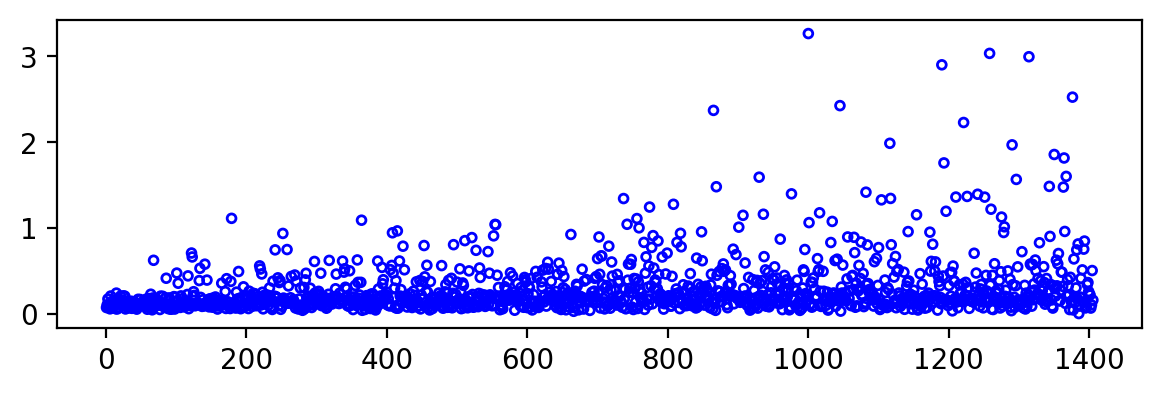

In [22]:
fig, ax = plt.subplots()
yy = data['mdpi_5']
xx = data['rank']
ax.scatter(xx, yy, marker='o', s=10, facecolors='none', edgecolors='b')

plt.gcf().set_size_inches(7, 2)
#ax.set_xlim(0.65, 1.01)
#ax.set_ylim(0.3, 1.1)

In [32]:
# get average 'MDPI ratio' for each country
c_mdpi = data.groupby('country')['mdpi_5'].mean()
c_impact = data.groupby('country')['impact_P'].mean()

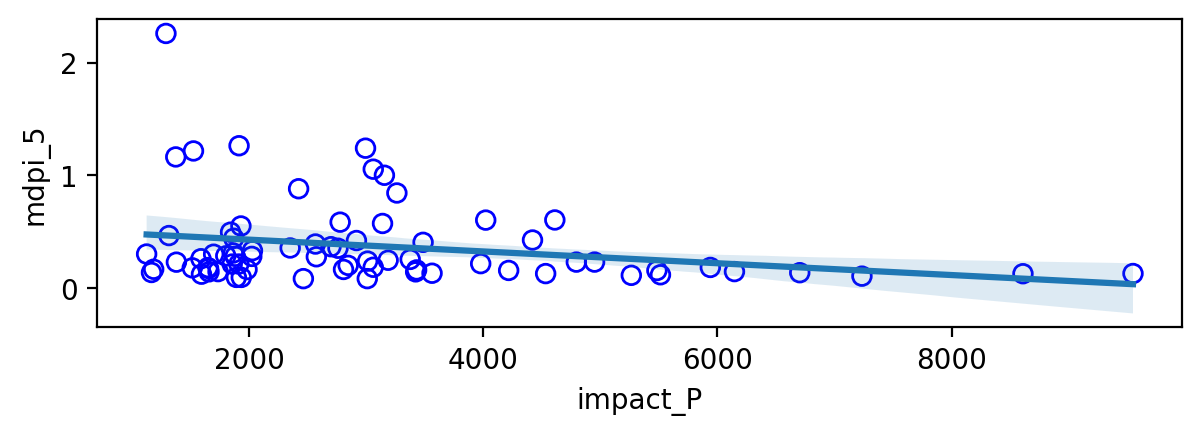

In [35]:
fig, ax = plt.subplots()
xx = c_impact
yy = c_mdpi
ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='b')
# fit data with a smooth line, show interval of confidence
sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.gcf().set_size_inches(7, 2)
# set y log scale
#ax.set_yscale('log')

In [5]:
countries = ['Denmark', 'Finland', 'Poland',
       'Greece', 'France', 'Romania', 'Germany', 'Italy', 'Czech Republic', 'Hungary', 'Spain', 'Sweden',
       'Slovakia', 'Netherlands', 'Ireland',
       'Cyprus', 'Belgium', 'Austria', 'Lithuania', 'Estonia', 'Portugal', 'Slovenia', 'Luxembourg', 'Croatia']

In [6]:
country_codes = ['DK', 'FI', 'PL', 'GR', 'FR', 'RO', 'DE', 'IT', 'CZ', 'HU', 'ES', 'SE', 'SK', 'NL', 'IE', 'CY', 'BE', 'AT', 'LT', 'EE', 'PT', 'SI', 'LU', 'HR']

In [7]:
# check if all countries are present
for country in countries:
    if country not in df_sel['Country'].unique():
        print(country)

In [8]:
df = df_sel[df_sel['Country'].isin(countries)]

In [9]:
df

,University,ROR ID,Country,Field,Period,Frac_counting,impact_P,collab_P,oa_P,TCS,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
25,Aalborg University,04m5j1k67,Denmark,All sciences,2018-2021,1,5447.096005,12500.0,12500.0,43907.135800,...,0.094320,0.079440,0.074240,0.084160,0.261600,0.253920,0.269600,0.0,0.0,0.0
181,Aalto University,020hwjq30,Finland,All sciences,2018-2021,1,4103.311991,9287.0,9287.0,37563.518978,...,0.232906,0.042856,0.038872,0.046840,0.337999,0.328739,0.346829,0.0,0.0,0.0
337,Aarhus University,01aj84f44,Denmark,All sciences,2018-2021,1,9417.490922,21868.0,21868.0,76375.783953,...,0.132385,0.099872,0.096214,0.104125,0.201527,0.196269,0.206512,0.0,0.0,0.0
493,Åbo Akademi University,029pk6x14,Finland,All sciences,2018-2021,1,1141.395043,3284.0,3284.0,8439.051381,...,0.255481,0.056029,0.048417,0.064251,0.140682,0.128502,0.152253,0.0,0.0,0.0
961,Adam Mickiewicz University in Poznań,04g6bbq64,Poland,All sciences,2018-2021,1,2552.839107,5069.0,5069.0,14110.247941,...,0.183665,0.043796,0.038272,0.050109,0.107122,0.098442,0.115013,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210469,Warsaw University of Technology,00y0xnp53,Poland,All sciences,2018-2021,1,3305.201168,5768.0,5768.0,13106.650324,...,0.129334,0.025485,0.021671,0.029473,0.069868,0.062587,0.076630,0.0,0.0,0.0
211717,"West Pomeranian University of Technology, Szcz...",0596m7f19,Poland,All sciences,2018-2021,1,1379.715381,2110.0,2110.0,7663.357275,...,0.098578,0.015640,0.010427,0.021327,0.025118,0.019431,0.031280,0.0,0.0,0.0
212653,Wrocław Medical University,01qpw1b93,Poland,All sciences,2018-2021,1,1747.678736,3667.0,3667.0,11524.523705,...,0.122989,0.073902,0.065721,0.082356,0.054268,0.047178,0.061085,0.0,0.0,0.0
212809,Wroclaw University of Environmental and Life S...,05cs8k179,Poland,All sciences,2018-2021,1,1183.573870,2229.0,2229.0,7590.524549,...,0.140422,0.013010,0.008973,0.017945,0.025123,0.018843,0.031853,0.0,0.0,0.0


In [10]:
# sort df by 'impact_P' in descending order
df = df.sort_values(by='impact_P', ascending=False)

In [11]:
# show first 20 rows 
df.head(50)

,University,ROR ID,Country,Field,Period,Frac_counting,impact_P,collab_P,oa_P,TCS,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
161641,University of Copenhagen,035b05819,Denmark,All sciences,2018-2021,1,16088.948672,36383.0,36383.0,144051.657697,...,0.142017,0.133002,0.129456,0.136162,0.146222,0.142786,0.150043,0.0,0.0,0.0
64453,Katholieke Universiteit Leuven,05f950310,Belgium,All sciences,2018-2021,1,14112.951935,32641.0,32641.0,137096.147443,...,0.135504,0.098251,0.095126,0.101376,0.334671,0.329677,0.340186,0.0,0.0,0.0
39805,Ghent University,00cv9y106,Belgium,All sciences,2018-2021,1,12297.363443,27037.0,27037.0,108568.083938,...,0.113511,0.080297,0.077080,0.083330,0.220698,0.215889,0.225839,0.0,0.0,0.0
110785,Sapienza University of Rome,02be6w209,Italy,All sciences,2018-2021,1,12257.903181,28633.0,28633.0,88778.017889,...,0.093948,0.080082,0.076869,0.083295,0.167744,0.163308,0.172109,0.0,0.0,0.0
207817,Utrecht University,04pp8hn57,Netherlands,All sciences,2018-2021,1,12046.595857,31989.0,31989.0,125494.722317,...,0.316703,0.087124,0.084154,0.090344,0.158367,0.154553,0.162149,0.0,0.0,0.0
185821,University of Padova,00240q980,Italy,All sciences,2018-2021,1,11030.573577,25145.0,25145.0,86355.912552,...,0.111990,0.096361,0.092742,0.100219,0.157009,0.152277,0.161503,0.0,0.0,0.0
127477,Technical University of Munich,02kkvpp62,Germany,All sciences,2018-2021,1,10744.557770,25305.0,25305.0,93550.584085,...,0.181348,0.070302,0.067259,0.073582,0.151670,0.147362,0.156214,0.0,0.0,0.0
167101,University of Groningen,012p63287,Netherlands,All sciences,2018-2021,1,10690.575921,24876.0,24876.0,104649.818320,...,0.321193,0.098046,0.094227,0.101664,0.287586,0.281959,0.293375,0.0,0.0,0.0
46981,Heidelberg University,038t36y30,Germany,All sciences,2018-2021,1,10315.511737,29379.0,29379.0,102773.911767,...,0.196161,0.115593,0.112053,0.119099,0.123013,0.119031,0.127030,0.0,0.0,0.0
154777,University of Bologna,01111rn36,Italy,All sciences,2018-2021,1,10228.849678,23457.0,23457.0,73794.346213,...,0.107090,0.088332,0.084580,0.092126,0.190391,0.185360,0.195379,0.0,0.0,0.0


In [12]:
# reset index of df
df = df.reset_index(drop=True)

In [13]:
df

,University,ROR ID,Country,Field,Period,Frac_counting,impact_P,collab_P,oa_P,TCS,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
0,University of Copenhagen,035b05819,Denmark,All sciences,2018-2021,1,16088.948672,36383.0,36383.0,144051.657697,...,0.142017,0.133002,0.129456,0.136162,0.146222,0.142786,0.150043,0.0,0.0,0.0
1,Katholieke Universiteit Leuven,05f950310,Belgium,All sciences,2018-2021,1,14112.951935,32641.0,32641.0,137096.147443,...,0.135504,0.098251,0.095126,0.101376,0.334671,0.329677,0.340186,0.0,0.0,0.0
2,Ghent University,00cv9y106,Belgium,All sciences,2018-2021,1,12297.363443,27037.0,27037.0,108568.083938,...,0.113511,0.080297,0.077080,0.083330,0.220698,0.215889,0.225839,0.0,0.0,0.0
3,Sapienza University of Rome,02be6w209,Italy,All sciences,2018-2021,1,12257.903181,28633.0,28633.0,88778.017889,...,0.093948,0.080082,0.076869,0.083295,0.167744,0.163308,0.172109,0.0,0.0,0.0
4,Utrecht University,04pp8hn57,Netherlands,All sciences,2018-2021,1,12046.595857,31989.0,31989.0,125494.722317,...,0.316703,0.087124,0.084154,0.090344,0.158367,0.154553,0.162149,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,"University of Veterinary Medicine Hannover, Fo...",015qjqf64,Germany,All sciences,2018-2021,1,842.142938,1866.0,1866.0,6846.690485,...,0.138800,0.054662,0.045016,0.064845,0.050375,0.040729,0.061093,0.0,0.0,0.0
333,Université Sorbonne Paris Nord,0199hds37,France,All sciences,2018-2021,1,841.714386,4920.0,4920.0,5711.135020,...,0.183943,0.102033,0.093902,0.110163,0.190244,0.179268,0.200813,0.0,0.0,0.0
334,Université de Versailles Saint-Quentin-en-Yvel...,03mkjjy25,France,All sciences,2018-2021,1,816.455235,8286.0,8286.0,6910.132632,...,0.193580,0.151822,0.144702,0.159546,0.189838,0.181632,0.198407,0.0,0.0,0.0
335,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,All sciences,2018-2021,1,741.590753,2548.0,2548.0,4320.484272,...,0.102433,0.070644,0.061224,0.080455,0.105181,0.093407,0.116954,0.0,0.0,0.0


In [34]:
# ror = "035b05819"
# rows = []
rank = 218
for uni, ror in df[['University','ROR ID']].values[218:]:
    pager = Works().filter(authorships={"institutions": {"ror": ror}}, publication_year=2023).paginate(per_page=200, n_max=None)

    w = []
    c = 0
    for page in pager:
        w.extend(page)
        c += len(page)
        #print(c)

    publishers = []
    for p in w:
        if 'primary_location' in p.keys():
            if p['primary_location']:
                if 'source' in p['primary_location'].keys():
                    if p['primary_location']['source']:
                        if 'host_organization_name' in p['primary_location']['source'].keys():
                            publishers.append(p['primary_location']['source']['host_organization_name'])

    publishers = [x for x in publishers if x is not None]
    ratio = 400
    if publishers:
        s = sum(Counter(publishers).values())
        publ = Counter(publishers)
        if 'Multidisciplinary Digital Publishing Institute' in publ.keys() and s>0:
            ratio = publ['Multidisciplinary Digital Publishing Institute']/s
            rows.append([rank, uni, ror, ratio])
        #ratio = Counter(publishers)['Multidisciplinary Digital Publishing Institute']/sum(Counter(publishers).values())
    #ratio = Counter(publishers)['Multidisciplinary Digital Publishing Institute']/sum(Counter(publishers).values())
    #mdpi = Counter(publishers)['Multidisciplinary Digital Publishing Institute']
    rank += 1
    #rows.append([rank, uni, ror, ratio])
    print(rank, uni, ror, ratio)


219 Rey Juan Carlos University 01v5cv687 0.1575091575091575
220 University of Alcalá 04pmn0e78 0.13586358635863585
221 University of Ioannina 01qg3j183 0.27593659942363113
222 University of Cádiz 04mxxkb11 0.1931179775280899
223 Roma Tre University 05vf0dg29 0.12801755669348938
224 Johannes Kepler University Linz 052r2xn60 0.08200290275761973
225 University of Konstanz 0546hnb39 0.028897338403041824
226 University of A Coruña 01qckj285 0.1246983105390185
227 Poznań University of Medical Sciences 02zbb2597 0.3458009880028229
228 University of Greifswald 00r1edq15 0.11855670103092783
229 Universität zu Lübeck 00t3r8h32 0.07270773638968481
230 Vita-Salute San Raffaele University 01gmqr298 0.10461229946524064
231 Wrocław Medical University 01qpw1b93 0.32545577312626606
232 Universidad de Almería 003d3xx08 0.2202797202797203
233 University of Luxembourg 036x5ad56 0.04742857142857143
234 Luleå University of Technology 016st3p78 0.10583941605839416
235 University of Łódź 05cq64r17 0.131848284

In [271]:
w[0]

{'id': 'https://openalex.org/W4291017541',
 'doi': 'https://doi.org/10.1016/j.ejor.2022.05.034',
 'title': 'Traceability vs. sustainability in supply chains: The implications of blockchain',
 'display_name': 'Traceability vs. sustainability in supply chains: The implications of blockchain',
 'publication_year': 2023,
 'publication_date': '2023-02-01',
 'ids': {'openalex': 'https://openalex.org/W4291017541',
  'doi': 'https://doi.org/10.1016/j.ejor.2022.05.034'},
 'language': 'en',
 'primary_location': {'is_oa': False,
  'landing_page_url': 'https://doi.org/10.1016/j.ejor.2022.05.034',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S103321696',
   'display_name': 'European Journal of Operational Research',
   'issn_l': '0377-2217',
   'issn': ['1872-6860', '0377-2217'],
   'is_oa': False,
   'is_in_doaj': False,
   'host_organization': 'https://openalex.org/P4310320990',
   'host_organization_name': 'Elsevier BV',
   'host_organization_lineage': ['https://openalex.org/P4310

In [47]:
np.save('mdpi_ratio_leiden.npy', rows)
#rows = np.load('mdpi_ratio_Leiden_Uni_218.npy', allow_pickle=True)

In [33]:
rows[0]

array(['0', 'University of Copenhagen', '035b05819',
       '0.04962779156327544'], dtype='<U57')

In [20]:
# get uni, ror in df[['University','ROR ID']].values from row 217 and on
rows = []
rank = 217
for uni, ror in df[['University','ROR ID']].values[218:]:
    print(rank, uni, ror)


217 Rey Juan Carlos University 01v5cv687
217 University of Alcalá 04pmn0e78
217 University of Ioannina 01qg3j183
217 University of Cádiz 04mxxkb11
217 Roma Tre University 05vf0dg29
217 Johannes Kepler University Linz 052r2xn60
217 University of Konstanz 0546hnb39
217 University of A Coruña 01qckj285
217 Poznań University of Medical Sciences 02zbb2597
217 University of Greifswald 00r1edq15
217 Universität zu Lübeck 00t3r8h32
217 Vita-Salute San Raffaele University 01gmqr298
217 Wrocław Medical University 01qpw1b93
217 Universidad de Almería 003d3xx08
217 University of Luxembourg 036x5ad56
217 Luleå University of Technology 016st3p78
217 University of Łódź 05cq64r17
217 Palacký University Olomouc 04qxnmv42
217 University of Hohenheim 00b1c9541
217 Carl von Ossietzky University of Oldenburg 033n9gh91
217 Medical University of Łódź 02t4ekc95
217 Technische Universität Kaiserslautern 04zrf7b53
217 University of Wrocław 00yae6e25
217 Tilburg University 04b8v1s79
217 Universidad de La Laguna 

In [44]:
# cast rows to df
df_mdpi = pd.DataFrame(rows, columns=['Rank', 'University', 'ROR ID', 'MDPI ratio'])
# cast 'MDPI ratio' to float
df_mdpi['MDPI ratio'] = df_mdpi['MDPI ratio'].astype(float)
# cast 'Rank' to int
df_mdpi['Rank'] = df_mdpi['Rank'].astype(int)

In [45]:
df_mdpi

,Rank,University,ROR ID,MDPI ratio
0,0,University of Copenhagen,035b05819,0.049628
1,1,Katholieke Universiteit Leuven,05f950310,0.055502
2,2,Ghent University,00cv9y106,0.082782
3,3,Sapienza University of Rome,02be6w209,0.195766
4,4,Utrecht University,04pp8hn57,0.044236
...,...,...,...,...
331,332,"University of Veterinary Medicine Hannover, Fo...",015qjqf64,0.229656
332,333,Université Sorbonne Paris Nord,0199hds37,0.065905
333,334,Université de Versailles Saint-Quentin-en-Yvel...,03mkjjy25,0.056398
334,335,University of South Bohemia in České Budějovice,033n3pw66,0.100654


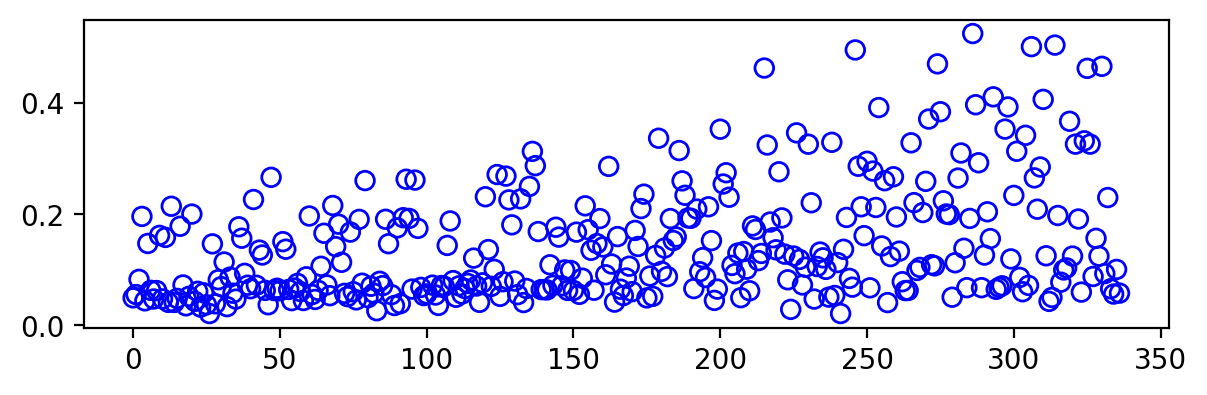

In [46]:
# plot rank vs ration from rows
#rank, uni, ror, ratio = zip(*rows)
fig, ax = plt.subplots()
yy = df_mdpi['MDPI ratio']
xx = df_mdpi['Rank']
ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='b')

plt.gcf().set_size_inches(7, 2)
#ax.set_xlim(0.65, 1.01)
#ax.set_ylim(0.3, 1.1)

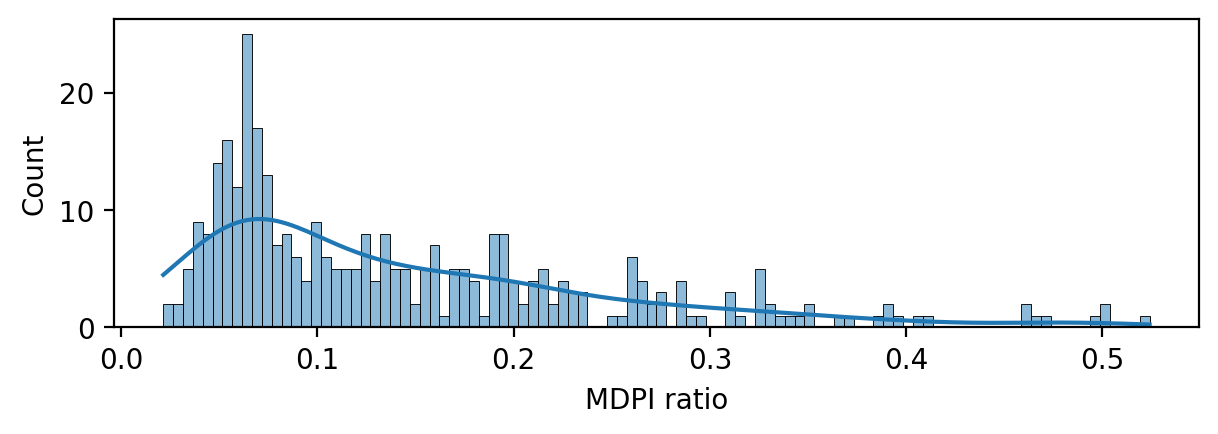

In [50]:
# plot distribution of 'MDPI ratio'
fig, ax = plt.subplots()
sns.histplot(df_mdpi['MDPI ratio'], kde=True, bins=100, ax=ax)
plt.gcf().set_size_inches(7, 2)


In [54]:
df.columns

Index(['University', 'ROR ID', 'Country', 'Field', 'Period', 'Frac_counting',
       'impact_P', 'collab_P', 'oa_P', 'TCS', 'TNCS', 'P_top1', 'P_top5',
       'P_top10', 'P_top50', 'P_collab', 'P_int_collab', 'P_industry_collab',
       'P_short_dist_collab', 'P_long_dist_collab', 'P_OA', 'P_gold_OA',
       'P_hybrid_OA', 'P_bronze_OA', 'P_green_OA', 'P_OA_unknown', 'MCS',
       'MCS_lb', 'MCS_ub', 'MNCS', 'MNCS_lb', 'MNCS_ub', 'PP_top1',
       'PP_top1_lb', 'PP_top1_ub', 'PP_top5', 'PP_top5_lb', 'PP_top5_ub',
       'PP_top10', 'PP_top10_lb', 'PP_top10_ub', 'PP_top50', 'PP_top50_lb',
       'PP_top50_ub', 'PP_collab', 'PP_collab_lb', 'PP_collab_ub',
       'PP_int_collab', 'PP_int_collab_lb', 'PP_int_collab_ub',
       'PP_industry_collab', 'PP_industry_collab_lb', 'PP_industry_collab_ub',
       'PP_short_dist_collab', 'PP_short_dist_collab_lb',
       'PP_short_dist_collab_ub', 'PP_long_dist_collab',
       'PP_long_dist_collab_lb', 'PP_long_dist_collab_ub', 'PP_OA', 'PP_OA_lb',


In [55]:
# to df_mdpi add 'Country' from df
df_mdpi = pd.merge(df_mdpi, df[['University', 'Country', 'impact_P', 'TCS', 'TNCS', 'P_top1', 'P_top5', 'P_top10', 'P_top50']], on='University', how='left')

In [56]:
df_mdpi

,Rank,University,ROR ID,MDPI ratio,Country_x,Country_y,impact_P,TCS,TNCS,P_top1,P_top5,P_top10,P_top50
0,0,University of Copenhagen,035b05819,0.049628,Denmark,Denmark,16088.948672,144051.657697,18999.392146,217.524904,1018.652457,1982.867982,9154.899989
1,1,Katholieke Universiteit Leuven,05f950310,0.055502,Belgium,Belgium,14112.951935,137096.147443,18176.699646,224.091795,1013.947895,1919.696644,8328.011897
2,2,Ghent University,00cv9y106,0.082782,Belgium,Belgium,12297.363443,108568.083938,14732.799944,167.394059,798.801973,1556.932368,7134.546341
3,3,Sapienza University of Rome,02be6w209,0.195766,Italy,Italy,12257.903181,88778.017889,12439.506034,106.560225,630.470555,1304.472644,6479.028597
4,4,Utrecht University,04pp8hn57,0.044236,Netherlands,Netherlands,12046.595857,125494.722317,17037.478549,227.365164,1004.274939,1880.185312,7490.925535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,332,"University of Veterinary Medicine Hannover, Fo...",015qjqf64,0.229656,Germany,Germany,842.142938,6846.690485,779.874023,4.407184,25.647477,62.372592,416.151945
332,333,Université Sorbonne Paris Nord,0199hds37,0.065905,France,France,841.714386,5711.135020,857.114124,10.735676,42.022353,81.189909,398.541672
333,334,Université de Versailles Saint-Quentin-en-Yvel...,03mkjjy25,0.056398,France,France,816.455235,6910.132632,884.321803,10.626669,42.909107,86.992749,417.716299
334,335,University of South Bohemia in České Budějovice,033n3pw66,0.100654,Czech Republic,Czech Republic,741.590753,4320.484272,699.402928,7.726232,34.738333,70.010760,370.936600


In [84]:
# get average 'MDPI ratio' for each country
c_mdpi = df_mdpi.groupby('Country_x')['MDPI ratio'].mean()
c_impact = df_mdpi.groupby('Country_x')['P_top10'].sum()/df_mdpi.groupby('Country_x')['impact_P'].sum()

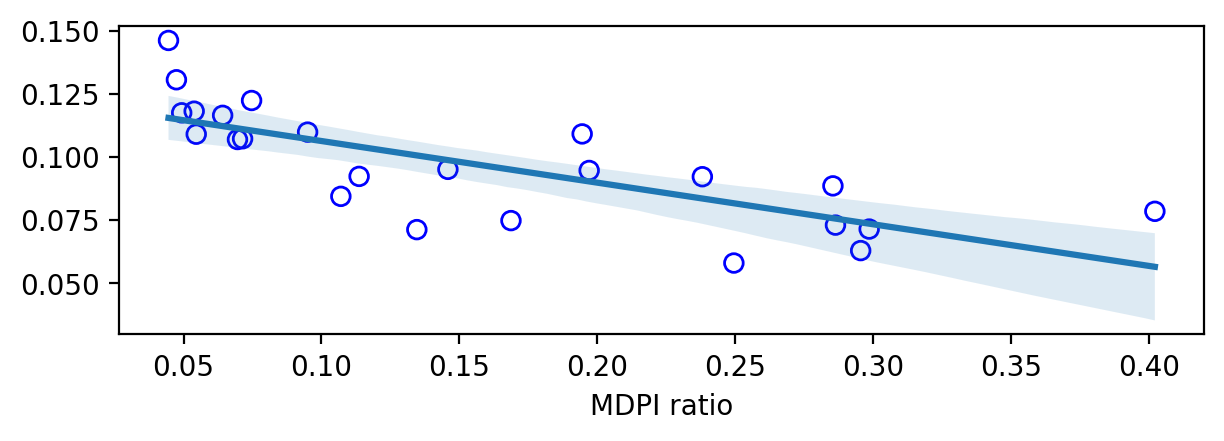

In [85]:
# plot c_mdpi vs c_p1
fig, ax = plt.subplots()
yy = c_impact
xx = c_mdpi
ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='b')
# fit data with a smooth line, show interval of confidence
sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.gcf().set_size_inches(7, 2)


In [65]:
c_p1

Country_x
Austria            337.433634
Belgium            634.254054
Croatia             38.418797
Cyprus              28.826381
Czech Republic     131.156644
Denmark            535.641093
Estonia             36.885050
Finland            306.869682
France             957.400275
Germany           2400.125029
Greece             219.013622
Hungary             82.738212
Ireland            248.722115
Italy             1861.375609
Lithuania           17.393771
Luxembourg          27.046445
Netherlands       1513.731909
Poland             438.782894
Portugal           332.929575
Romania             46.036532
Slovakia            19.757768
Slovenia            53.326163
Spain             1084.590029
Sweden             755.917085
Name: P_top1, dtype: float64

In [86]:
df_country = df_mdpi.groupby('Country_x').agg({'MDPI ratio': 'mean', 'impact_P': 'sum', 'P_top10': 'sum', 'P_top50': 'sum', 'P_top5': 'sum', 'P_top1': 'sum', 'TCS': 'sum', 'TNCS': 'sum'}).reset_index()

In [87]:
df_country

,Country_x,MDPI ratio,impact_P,P_top10,P_top50,P_top5,P_top1,TCS,TNCS
0,Austria,0.095001,30877.326659,3393.655675,16453.813474,1706.754327,337.433634,2.371235e+05,33766.117163
1,Belgium,0.074685,47513.365002,5816.682872,27019.192992,2970.332580,634.254054,4.141601e+05,56031.390977
2,Croatia,0.286431,5986.611323,437.559517,2692.534282,207.625946,38.418797,3.194233e+04,4988.182768
3,Cyprus,0.113682,3369.372892,311.262094,1618.369288,158.900055,28.826381,2.433169e+04,3095.925875
4,Czech Republic,0.134613,21145.330842,1507.691693,9219.299792,694.658129,131.156644,1.134821e+05,17004.318658
5,Denmark,0.053863,43050.329367,5088.218504,24266.017002,2635.441547,535.641093,3.782910e+05,49594.819471
6,Estonia,0.107059,3598.945009,304.021451,1637.329006,149.604150,36.885050,2.513510e+04,3357.111869
7,Finland,0.054611,28492.774174,3108.042984,15691.456114,1519.338250,306.869682,2.208154e+05,31280.932177
8,France,0.069568,92574.423128,9903.910257,48682.581948,4873.172972,957.400275,7.203223e+05,97348.381623
9,Germany,0.071422,226699.627842,24321.068487,120685.194385,12030.431539,2400.125029,1.804061e+06,241754.589899


In [89]:
df_indicators = pd.read_excel('../autonomy/indicators.xlsx')

In [90]:
df_indicators

,Country,PC,CC,CPI,Code,AA,SA,FA,OA,norm_Autonomy,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Sweden,0.982,0.992,0.82,SE,0.670000,0.970000,0.560000,0.590000,0.687204,...,0.765167,0.917789,0.940802,0.902056,10612.086,0.065855,64578.396333,Sweden,1.641757,1.200146
1,Poland,0.863,0.868,0.54,PL,0.680000,0.870000,0.600000,0.710000,0.720379,...,0.583164,0.795988,0.421845,0.621791,41026.067,0.274344,43268.543713,Poland,0.916413,0.004591
2,Portugal,0.906,0.848,0.61,PT,0.540000,0.620000,0.700000,0.800000,0.625592,...,0.453390,0.774925,0.750849,0.626022,10247.605,0.179513,41451.614866,Portugal,1.872676,0.780879
3,France,0.962,0.950,0.71,FR,0.420000,0.440000,0.440000,0.570000,0.251185,...,0.542736,0.767170,0.674634,0.678514,64756.584,0.075287,55492.565547,France,0.377710,1.033441
4,Germany,0.987,0.981,0.78,DE,0.876667,0.613333,0.406667,0.676667,0.584518,...,0.716512,0.854604,0.898402,0.843665,83294.633,0.082190,63149.598690,Germany,1.676135,1.898447
5,Ireland,0.980,0.959,0.77,IE,0.890000,0.580000,0.630000,0.760000,0.720379,...,0.556873,0.820507,0.854765,0.813091,5056.935,0.066482,126905.198534,Ireland,1.316353,1.354688
6,Italy,0.818,0.861,0.56,IT,0.560000,0.490000,0.700000,0.650000,0.502370,...,0.619005,0.754287,0.828770,0.703630,58870.762,0.168539,51864.977735,Italy,1.559570,1.036302
7,Latvia,0.886,0.896,0.60,LV,0.550000,0.890000,0.900000,0.690000,0.800948,...,0.760578,0.688060,0.801526,0.723622,1830.211,0.216367,39956.190477,Latvia,1.855769,1.262392
8,Netherlands,0.978,0.978,0.79,NL,0.460000,0.920000,0.660000,0.830000,0.725118,...,0.648766,0.889942,0.864005,0.819552,17618.299,0.055738,69577.404580,Netherlands,0.906708,2.218978
9,Spain,0.967,0.941,0.60,ES,0.570000,0.500000,0.550000,0.550000,0.393365,...,0.631988,0.767306,0.611952,0.788896,47519.628,0.131809,45825.195633,Spain,1.872676,1.401909


In [95]:
# rename 'Country_x' to 'Country' in df_country
df_country = df_country.rename(columns={'Country_x': 'Country'})

In [103]:
# rename 'Czech Republic' to 'Czechia' in df_country
df_country = df_country.replace('Czech Republic', 'Czechia')

In [104]:
# merge df_country with df_indicators on 'Country'
df_all = pd.merge(df_country, df_indicators, on='Country', how='left')

In [105]:
df_all

,Country,MDPI ratio,impact_P,P_top10,P_top50,P_top5,P_top1,TCS,TNCS,PC,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Austria,0.095001,30877.326659,3393.655675,16453.813474,1706.754327,337.433634,2.371235e+05,33766.117163,0.846,...,0.693538,0.867013,0.860433,0.836997,8958.960,0.093146,67935.847974,Austria,0.644490,0.956170
1,Belgium,0.074685,47513.365002,5816.682872,27019.192992,2970.332580,634.254054,4.141601e+05,56031.390977,0.985,...,0.673754,0.819730,0.854925,0.795829,11686.140,0.074502,65027.294895,Belgium,1.055057,1.141477
2,Croatia,0.286431,5986.611323,437.559517,2692.534282,207.625946,38.418797,3.194233e+04,4988.182768,0.694,...,0.465580,0.610512,0.468934,0.658390,4008.617,0.208929,40379.572436,Croatia,1.224281,1.949961
3,Cyprus,0.113682,3369.372892,311.262094,1618.369288,158.900055,28.826381,2.433169e+04,3095.925875,0.793,...,0.599164,0.680078,0.756919,0.683062,1260.138,0.140908,36269.546633,Cyprus,1.311128,0.496121
4,Czechia,0.134613,21145.330842,1507.691693,9219.299792,694.658129,131.156644,1.134821e+05,17004.318658,0.766,...,0.661411,0.748824,0.821102,0.796422,10495.295,0.130429,49945.500104,Czechia,1.972334,0.418134
5,Denmark,0.053863,43050.329367,5088.218504,24266.017002,2635.441547,535.641093,3.782910e+05,49594.819471,0.999,...,0.794332,0.988121,0.939104,0.905896,5910.913,0.056744,74005.478520,Denmark,1.113466,0.992659
6,Estonia,0.107059,3598.945009,304.021451,1637.329006,149.604150,36.885050,2.513510e+04,3357.111869,0.970,...,0.781101,0.877341,0.858461,0.809711,1322.765,0.126660,46697.359736,Estonia,1.872676,1.386168
7,Finland,0.054611,28492.774174,3108.042984,15691.456114,1519.338250,306.869682,2.208154e+05,31280.932177,0.981,...,0.803179,0.931366,0.989690,0.915227,5545.475,0.076539,59026.707335,Finland,1.668566,1.366135
8,France,0.069568,92574.423128,9903.910257,48682.581948,4873.172972,957.400275,7.203223e+05,97348.381623,0.962,...,0.542736,0.767170,0.674634,0.678514,64756.584,0.075287,55492.565547,France,0.377710,1.033441
9,Germany,0.071422,226699.627842,24321.068487,120685.194385,12030.431539,2400.125029,1.804061e+06,241754.589899,0.987,...,0.716512,0.854604,0.898402,0.843665,83294.633,0.082190,63149.598690,Germany,1.676135,1.898447


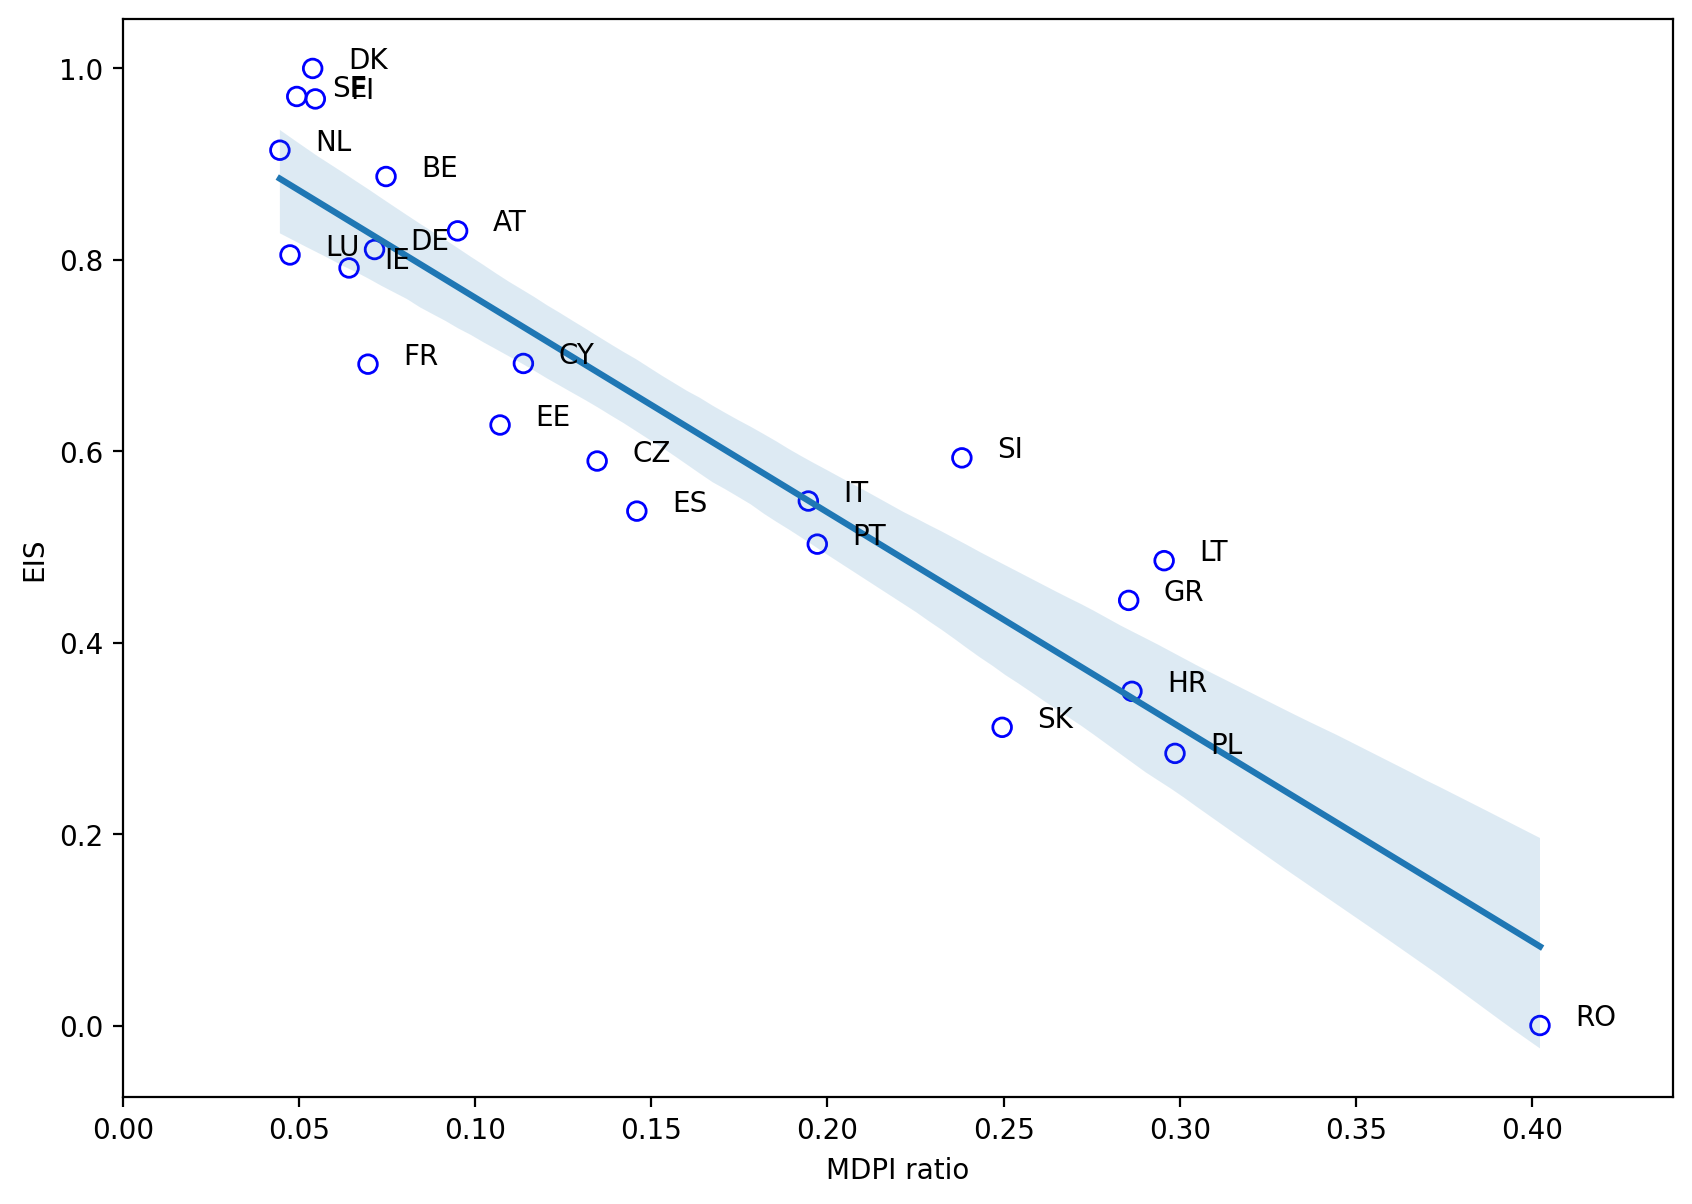

In [241]:
import numpy as np
from scipy.optimize import curve_fit
# plot 'MDPI ratio' vs 'MDPI 2023'
fig, ax = plt.subplots()
yy = df_all['norm_EIS']
#yy = df_all['impact_P']/df_all['Pop1K']
xx = df_all['MDPI ratio']
ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='b')

sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
# annotate points with 'Code'
for i, txt in enumerate(df_all['Code']):
    ax.annotate(txt, (xx[i]+0.01, yy[i]))



#ax.set_ylim(-1.5, 9.)
ax.set_xlim(0.0, .44)
ax.set_ylabel('EIS')
plt.gcf().set_size_inches(10, 7)


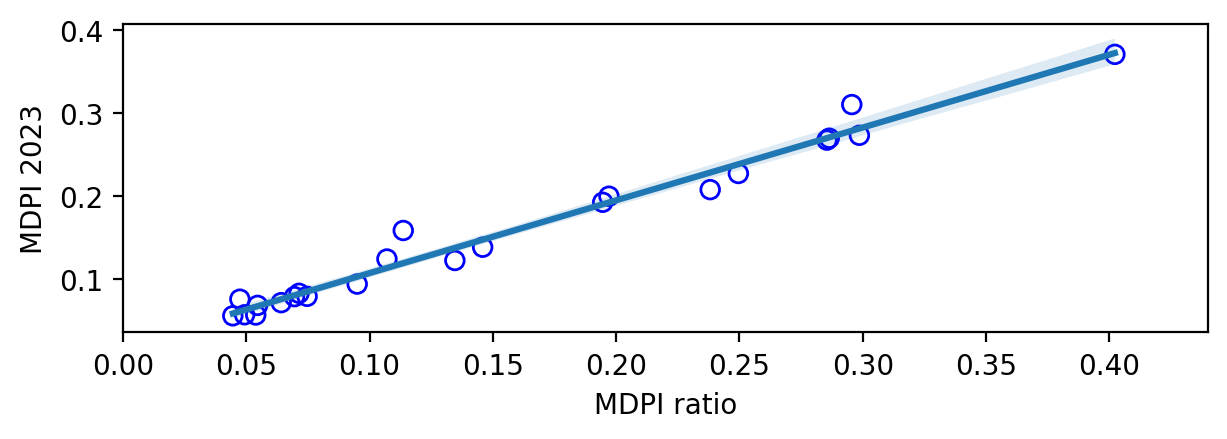

In [275]:
fig, ax = plt.subplots()
yy = df_all['MDPI 2023']
#yy = df_all['impact_P']/df_all['Pop1K']
xx = df_all['MDPI ratio']
ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='b')

sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
# annotate points with 'Code'
# for i, txt in enumerate(df_all['Code']):
#    ax.annotate(txt, (xx[i]+0.01, yy[i]))



#ax.set_ylim(-1.5, 9.)
ax.set_xlim(0.0, .44)
#ax.set_ylabel('EIS')
plt.gcf().set_size_inches(7, 2)

In [126]:
#df_all.to_excel('all_indicators.xlsx')

In [138]:
# show countries with 'MDPI ratio' < 0.1
df_all[df_all['MDPI ratio'] < 0.1]

,Country,MDPI ratio,impact_P,P_top10,P_top50,P_top5,P_top1,TCS,TNCS,PC,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Austria,0.095001,30877.326659,3393.655675,16453.813474,1706.754327,337.433634,2.371235e+05,33766.117163,0.846,...,0.693538,0.867013,0.860433,0.836997,8958.960,0.093146,67935.847974,Austria,0.644490,0.956170
1,Belgium,0.074685,47513.365002,5816.682872,27019.192992,2970.332580,634.254054,4.141601e+05,56031.390977,0.985,...,0.673754,0.819730,0.854925,0.795829,11686.140,0.074502,65027.294895,Belgium,1.055057,1.141477
5,Denmark,0.053863,43050.329367,5088.218504,24266.017002,2635.441547,535.641093,3.782910e+05,49594.819471,0.999,...,0.794332,0.988121,0.939104,0.905896,5910.913,0.056744,74005.478520,Denmark,1.113466,0.992659
7,Finland,0.054611,28492.774174,3108.042984,15691.456114,1519.338250,306.869682,2.208154e+05,31280.932177,0.981,...,0.803179,0.931366,0.989690,0.915227,5545.475,0.076539,59026.707335,Finland,1.668566,1.366135
8,France,0.069568,92574.423128,9903.910257,48682.581948,4873.172972,957.400275,7.203223e+05,97348.381623,0.962,...,0.542736,0.767170,0.674634,0.678514,64756.584,0.075287,55492.565547,France,0.377710,1.033441
9,Germany,0.071422,226699.627842,24321.068487,120685.194385,12030.431539,2400.125029,1.804061e+06,241754.589899,0.987,...,0.716512,0.854604,0.898402,0.843665,83294.633,0.082190,63149.598690,Germany,1.676135,1.898447
12,Ireland,0.064187,20578.032766,2398.413684,11004.775411,1273.762178,248.722115,1.636585e+05,22742.629892,0.980,...,0.556873,0.820507,0.854765,0.813091,5056.935,0.066482,126905.198534,Ireland,1.316353,1.354688
15,Luxembourg,0.047429,1733.362317,226.441556,986.866072,114.068105,27.046445,1.356649e+04,2092.235235,0.979,...,0.591117,0.863778,0.715467,0.858158,654.768,0.084337,142213.851685,Luxembourg,1.161275,0.930413
16,Netherlands,0.044559,94048.241778,13750.109790,56954.532275,7074.503141,1513.731909,9.077341e+05,124085.809469,0.978,...,0.648766,0.889942,0.864005,0.819552,17618.299,0.055738,69577.404580,Netherlands,0.906708,2.218978
23,Sweden,0.049340,63168.965778,7425.453452,35768.466603,3694.483312,755.917085,5.370013e+05,72327.814930,0.982,...,0.765167,0.917789,0.940802,0.902056,10612.086,0.065855,64578.396333,Sweden,1.641757,1.200146


In [139]:
df_all[df_all['MDPI ratio'] > 0.1]

,Country,MDPI ratio,impact_P,P_top10,P_top50,P_top5,P_top1,TCS,TNCS,PC,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
2,Croatia,0.286431,5986.611323,437.559517,2692.534282,207.625946,38.418797,3.194233e+04,4988.182768,0.694,...,0.465580,0.610512,0.468934,0.658390,4008.617,0.208929,40379.572436,Croatia,1.224281,1.949961
3,Cyprus,0.113682,3369.372892,311.262094,1618.369288,158.900055,28.826381,2.433169e+04,3095.925875,0.793,...,0.599164,0.680078,0.756919,0.683062,1260.138,0.140908,36269.546633,Cyprus,1.311128,0.496121
4,Czechia,0.134613,21145.330842,1507.691693,9219.299792,694.658129,131.156644,1.134821e+05,17004.318658,0.766,...,0.661411,0.748824,0.821102,0.796422,10495.295,0.130429,49945.500104,Czechia,1.972334,0.418134
6,Estonia,0.107059,3598.945009,304.021451,1637.329006,149.604150,36.885050,2.513510e+04,3357.111869,0.970,...,0.781101,0.877341,0.858461,0.809711,1322.765,0.126660,46697.359736,Estonia,1.872676,1.386168
10,Greece,0.285506,27535.260796,2440.139394,13287.668034,1183.253521,219.013622,1.864657e+05,25037.556573,0.757,...,0.433291,0.658080,0.547926,0.550065,10341.277,0.203465,36834.871089,Greece,1.604428,1.216601
11,Hungary,0.168750,11572.255534,866.477516,5431.875886,405.987798,82.738212,6.791392e+04,9868.313667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Italy,0.194568,188947.396006,20632.396392,100322.731436,10004.323650,1861.375609,1.426604e+06,198062.836740,0.818,...,0.619005,0.754287,0.828770,0.703630,58870.762,0.168539,51864.977735,Italy,1.559570,1.036302
14,Lithuania,0.295567,4116.356437,259.336147,1833.472492,106.546469,17.393771,2.141795e+04,3083.654505,0.895,...,0.789172,0.668854,0.787709,0.705485,2718.352,0.278062,48396.693545,Lithuania,1.972334,1.731742
17,Poland,0.298652,70775.141611,5062.043034,31792.994722,2391.713409,438.782894,3.928681e+05,57552.084893,0.863,...,0.583164,0.795988,0.421845,0.621791,41026.067,0.274344,43268.543713,Poland,0.916413,0.004591
18,Portugal,0.197108,36885.061610,3493.909962,18340.702084,1720.097846,332.929575,2.694675e+05,35286.150331,0.906,...,0.453390,0.774925,0.750849,0.626022,10247.605,0.179513,41451.614866,Portugal,1.872676,0.780879


In [127]:
df_all.columns

Index(['Country', 'MDPI ratio', 'impact_P', 'P_top10', 'P_top50', 'P_top5',
       'P_top1', 'TCS', 'TNCS', 'PC', 'CC', 'CPI', 'Code', 'AA', 'SA', 'FA',
       'OA', 'norm_Autonomy', 'norm_EIS', 'STEM PHD', 'PUBS', 'TOP CITED',
       'GDP', 'WOS/Pop1K', 'CIT/Pop1K', '% Docs Cited', 'Democracy Index',
       'Control of corruption', 'MDPI 2023',
       'WJP Rule of Law Index: Overall Score',
       'Factor 1: Constraints on Government Powers',
       '1.1 Government powers are effectively limited by the legislature',
       '1.2 Government powers are effectively limited by the judiciary',
       '1.3 Government powers are effectively limited by independent auditing and review',
       '1.4 Government officials are sanctioned for misconduct',
       '1.5 Government powers are subject to non-governmental checks',
       '1.6 Transition of power is subject to the law',
       'Factor 2: Absence of Corruption',
       '2.1 Government officials in the executive branch do not use public offi

In [265]:
# show 'University of Ljubljana' and 'University of Maribor' rows in df
umul = df[df['University'].str.contains('Ljubljana|Maribor')][['University','impact_P','P_top10','P_top50','P_top5','P_top1','PP_top1','PP_top5','PP_top10','PP_top50']]


In [266]:
umul

,University,impact_P,P_top10,P_top50,P_top5,P_top1,PP_top1,PP_top5,PP_top10,PP_top50
77,University of Ljubljana,4910.429263,449.217045,2453.620120,223.271029,37.795978,0.007697,0.045469,0.091482,0.499675
247,University of Maribor,1611.939976,152.461861,800.270173,81.003834,15.530185,0.009634,0.050252,0.094583,0.496464


In [269]:
# compute ratio of imact_P between 'University of Ljubljana' and 'University of Maribor' add to new row 'ratio'
r = ['ratio',umul['impact_P'].iloc[0]/umul['impact_P'].iloc[1], umul['P_top10'].iloc[0]/umul['P_top10'].iloc[1], 
     umul['P_top50'].iloc[0]/umul['P_top50'].iloc[1], umul['P_top5'].iloc[0]/umul['P_top5'].iloc[1], umul['P_top1'].iloc[0]/umul['P_top1'].iloc[1],
     np.nan, np.nan, np.nan, np.nan]

r
# add r as row to umul, padding with NaN values 
umul = umul.append(pd.Series(r, index=umul.columns), ignore_index=True)


In [270]:
umul

,University,impact_P,P_top10,P_top50,P_top5,P_top1,PP_top1,PP_top5,PP_top10,PP_top50
0,University of Ljubljana,4910.429263,449.217045,2453.620120,223.271029,37.795978,0.007697,0.045469,0.091482,0.499675
1,University of Maribor,1611.939976,152.461861,800.270173,81.003834,15.530185,0.009634,0.050252,0.094583,0.496464
2,ratio,3.046285,2.946422,3.065990,2.756302,2.433711,NaN,NaN,NaN,NaN


In [191]:
# ration of 'University of Ljubljana' and 'University of Maribor' in df['impact_P']
df[df['University'].str.contains('Ljubljana')]['impact_P'].values/df[df['University'].str.contains('Maribor')]['impact_P'].values

array([3.04628543])

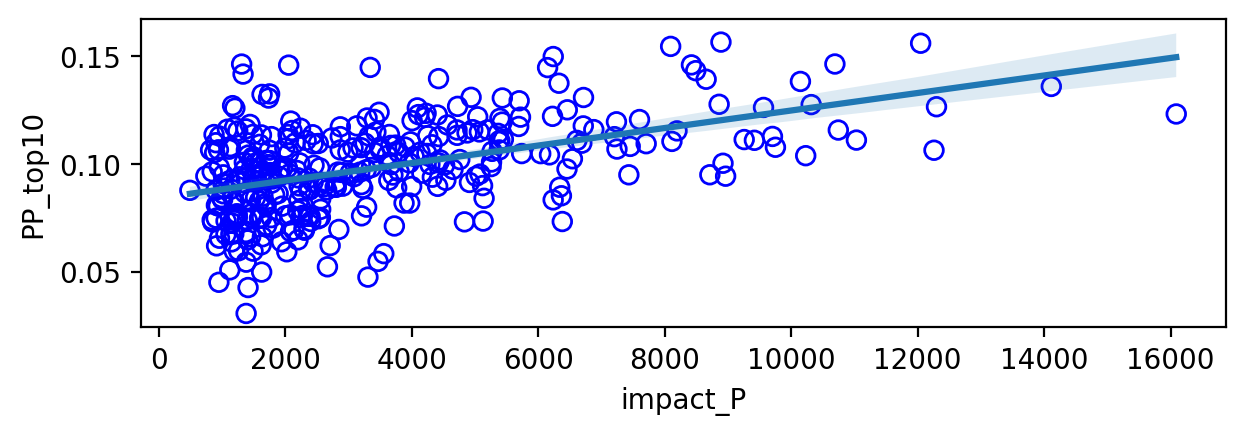

In [200]:
# plot 'PP_top1' vs 'impact_P' in df
fig, ax = plt.subplots()
yy = df['PP_top10']
xx = df['impact_P']
ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='b')
# fit data with a smooth line, show interval of confidence
sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.gcf().set_size_inches(7, 2)


In [ ]:
####################

In [146]:

rows_country = []
rank = 0
for code in country_codes:
    pager = Works().filter(institutions={"country_code": code}, publication_year=2023).paginate(per_page=200, n_max=None)


    w = []
    c = 0
    for page in pager:
        w.extend(page)
        c += len(page)
        #print(c)

    publishers = []
    for p in w:
        if 'primary_location' in p.keys():
            if p['primary_location']:
                if 'source' in p['primary_location'].keys():
                    if p['primary_location']['source']:
                        if 'host_organization_name' in p['primary_location']['source'].keys():
                            publishers.append(p['primary_location']['source']['host_organization_name'])

    publishers = [x for x in publishers if x is not None]
    ratio = Counter(publishers)['Multidisciplinary Digital Publishing Institute']/sum(Counter(publishers).values())
    rank += 1
    rows_country.append([code, ratio])
    print(code, ratio)

DK 0.04656764351665998
FI 0.056609390949302486
PL 0.2146352831507807
GR 0.22410326524046967
FR 0.054469304692751463
RO 0.34768149589006714
DE 0.060804411226872475


In [123]:
rank = 0
for uni, ror in df[['University','ROR ID']].values:
    print(rank,uni,ror)
    rank += 1

0 University of Copenhagen 035b05819
1 Katholieke Universiteit Leuven 05f950310
2 Ghent University 00cv9y106
3 Sapienza University of Rome 02be6w209
4 Utrecht University 04pp8hn57
5 University of Padova 00240q980
6 Technical University of Munich 02kkvpp62
7 University of Groningen 012p63287
8 Heidelberg University 038t36y30
9 University of Bologna 01111rn36
10 Karolinska Institutet 056d84691
11 University of Milan 00wjc7c48
12 Lund University 012a77v79
13 University of Naples Federico II 05290cv24
14 Aarhus University 01aj84f44
15 University of Helsinki 040af2s02
16 Universidade de Lisboa 01c27hj86
17 RWTH Aachen University 04xfq0f34
18 University of Amsterdam 04dkp9463
19 Ludwig-Maximilians-Universität München 05591te55
20 University of Porto 043pwc612
21 Radboud University 016xsfp80
22 Delft University of Technology 02e2c7k09
23 Leiden University 027bh9e22
24 Universität Hamburg 00g30e956
25 Uppsala University 048a87296
26 Erasmus University Rotterdam 057w15z03
27 University of Flore

In [278]:
# sort df by 'PP_top1' in descending order
df = df.sort_values(by='PP_top1', ascending=False)

In [289]:
df[['University', 'PP_top1']].head(140)

,University,PP_top1
4,Utrecht University,0.018874
229,Vita-Salute San Raffaele University,0.018795
18,University of Amsterdam,0.018152
46,Vrije Universiteit Amsterdam,0.017212
294,Lappeenranta–Lahti University of Technology,0.016929
...,...,...
30,Karlsruhe Institute of Technology,0.009722
25,Uppsala University,0.009700
284,Gustave Eiffel University (EPE),0.009686
66,Aix-Marseille University,0.009648


In [107]:
# group df_autonomy by 'Country', calculate sum
df_country = df.groupby('Country').sum()

In [108]:
df_country

,Frac_counting,impact_P,collab_P,oa_P,TCS,TNCS,P_top1,P_top5,P_top10,P_top50,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
Country,,,,,,,,,,,,,,,,,,,,,
Austria,12,30877.326659,75660.0,75660.0,2.371235e+05,33766.117163,337.433634,1706.754327,3393.655675,16453.813474,...,3.287543,0.795378,0.717059,0.876972,1.372329,1.270999,1.474441,0.0,0.0,0.0
Belgium,8,47513.365002,112644.0,112644.0,4.141601e+05,56031.390977,634.254054,2970.332580,5816.682872,27019.192992,...,1.007778,0.715612,0.673043,0.759663,2.038081,1.972405,2.104309,0.0,0.0,0.0
Croatia,2,5986.611323,11517.0,11517.0,3.194233e+04,4988.182768,38.418797,207.625946,437.559517,2692.534282,...,0.133993,0.110920,0.097179,0.125633,0.199399,0.182083,0.218336,0.0,0.0,0.0
Cyprus,3,3369.372892,7315.0,7315.0,2.433169e+04,3095.925875,28.826381,158.900055,311.262094,1618.369288,...,0.167743,0.137906,0.113596,0.162630,0.327609,0.292339,0.364520,0.0,0.0,0.0
Czech Republic,9,21145.330842,49715.0,49715.0,1.134821e+05,17004.318658,131.156644,694.658129,1507.691693,9219.299792,...,0.767705,0.434866,0.381572,0.491093,0.878762,0.803542,0.958127,0.0,0.0,0.0
Denmark,5,43050.329367,100545.0,100545.0,3.782910e+05,49594.819471,535.641093,2635.441547,5088.218504,24266.017002,...,0.628293,0.472749,0.452271,0.493900,1.291120,1.259515,1.322351,0.0,0.0,0.0
Estonia,2,3598.945009,8013.0,8013.0,2.513510e+04,3357.111869,36.885050,149.604150,304.021451,1637.329006,...,0.217987,0.109692,0.095521,0.124280,0.284211,0.262539,0.306799,0.0,0.0,0.0
Finland,9,32650.975735,77396.0,77396.0,2.469200e+05,35433.795954,342.994126,1714.147940,3506.228107,17797.613219,...,2.110513,0.580024,0.530264,0.630310,2.146574,2.056064,2.236693,0.0,0.0,0.0
France,33,92574.423128,443100.0,443100.0,7.203223e+05,97348.381623,957.400275,4873.172972,9903.910257,48682.581948,...,6.350634,2.984931,2.792103,3.184566,7.901160,7.618063,8.190379,0.0,0.0,0.0


In [13]:
# save df_autonomy_grouped to excel
#df_autonomy_grouped.to_excel('leiden-open-ranking-countries-sum.xlsx')


In [21]:
# find ror id in column 'ROR ID' for Slovenia in df
ror_id_slovenia = df[df['Country'] == 'Slovenia']['ROR ID'].to_list()

In [22]:
ror_id_slovenia

['05njb9z20', '01d5jce07']

In [23]:
# make a dictionary with country as key and ror_ids as value
ror_ids = {}
for country in countries:
    ror_ids[country] = df[df['Country'] == country]['ROR ID'].to_list()


In [26]:
ror_ids['Croatia']

['00m31ft63', '00mv6sv71']

In [57]:
pager = Works().filter(authorships={"institutions": {"ror": ["04m5j1k67|00mv6sv71"]}}, publication_year=2023).paginate(per_page=200, n_max=None)

w = []
c = 0
for page in pager:
    w.extend(page)
    c += len(page)
    print(c)

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9253
9253


In [142]:
pager = Works().filter(institutions={"country_code": "si"}, publication_year=2023).paginate(per_page=200, n_max=None)
w = []
c = 0
for page in pager:
    w.extend(page)
    c += len(page)
    print(c)

200
400
600
800


KeyboardInterrupt: 

In [145]:
w[1]

{'id': 'https://openalex.org/W4322734432',
 'doi': 'https://doi.org/10.1063/5.0146681',
 'title': 'Piezoelectric thin films for MEMS',
 'display_name': 'Piezoelectric thin films for MEMS',
 'publication_year': 2023,
 'publication_date': '2023-02-27',
 'ids': {'openalex': 'https://openalex.org/W4322734432',
  'doi': 'https://doi.org/10.1063/5.0146681'},
 'language': 'en',
 'primary_location': {'is_oa': True,
  'landing_page_url': 'https://doi.org/10.1063/5.0146681',
  'pdf_url': 'https://pubs.aip.org/aip/apl/article-pdf/doi/10.1063/5.0146681/16783720/090401_1_online.pdf',
  'source': {'id': 'https://openalex.org/S105243760',
   'display_name': 'Applied Physics Letters',
   'issn_l': '0003-6951',
   'issn': ['1520-8842', '0003-6951', '1077-3118'],
   'is_oa': False,
   'is_in_doaj': False,
   'host_organization': 'https://openalex.org/P4310320257',
   'host_organization_name': 'American Institute of Physics',
   'host_organization_lineage': ['https://openalex.org/P4310320257'],
   'host_

In [98]:
publishers = []
for p in w:
    if 'primary_location' in p.keys():
        if p['primary_location']:
            if 'source' in p['primary_location'].keys():
                if p['primary_location']['source']:
                    if 'host_organization_name' in p['primary_location']['source'].keys():
                        publishers.append(p['primary_location']['source']['host_organization_name'])

In [99]:
# remove None from list
publishers = [x for x in publishers if x is not None]

In [100]:
Counter(publishers)['Multidisciplinary Digital Publishing Institute']/sum(Counter(publishers).values())

0.04656764351665998

In [101]:
Counter(publishers).most_common(20)

[('Elsevier BV', 8194),
 ('Wiley-Blackwell', 2337),
 ('Oxford University Press', 1940),
 ('Springer Science+Business Media', 1887),
 ('Multidisciplinary Digital Publishing Institute', 1624),
 ('Taylor & Francis', 1193),
 ('Cold Spring Harbor Laboratory', 1088),
 ('Springer Nature', 1077),
 ('Wiley', 971),
 ('Nature Portfolio', 955),
 ('Frontiers Media', 887),
 ('SAGE Publishing', 775),
 ('BioMed Central', 705),
 ('Institute of Electrical and Electronics Engineers', 673),
 ('Lippincott Williams & Wilkins', 659),
 ('Research Square (United States)', 593),
 ('American Chemical Society', 558),
 ('IOP Publishing', 459),
 ('BMJ', 420),
 ('National Institutes of Health', 403)]

In [86]:
# find  all publishers that contain 'elsevier'
elsevier = [p for p,v in Counter(publishers).most_common()  if 'springer' in p.lower()]

In [88]:
# sum all values in Counter(publishers).most_common()
sum(Counter(publishers).values())

14932

In [91]:
Counter(publishers)['Multidisciplinary Digital Publishing Institute']/sum(Counter(publishers).values())

0.20486204125368337

In [66]:
# group df_autonomy by 'Country', calculate mean and std
df_autonomy_grouped_mean = df_autonomy.groupby('Country').mean()
df_autonomy_grouped_std = df_autonomy.groupby('Country').std()


In [67]:
df_autonomy_grouped_mean

,Frac_counting,impact_P,collab_P,oa_P,TCS,TNCS,P_top1,P_top5,P_top10,P_top50,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
Country,,,,,,,,,,,,,,,,,,,,,
Austria,1.0,2573.110555,6305.000000,6305.000000,19760.288801,2813.843097,28.119469,142.229527,282.804640,1371.151123,...,0.273962,0.066281,0.059755,0.073081,0.114361,0.105917,0.122870,0.0,0.0,0.0
Croatia,1.0,2993.305662,5758.500000,5758.500000,15971.163500,2494.091384,19.209399,103.812973,218.779758,1346.267141,...,0.066996,0.055460,0.048589,0.062816,0.099699,0.091042,0.109168,0.0,0.0,0.0
Denmark,1.0,8610.065873,20109.000000,20109.000000,75658.197088,9918.963894,107.128219,527.088309,1017.643701,4853.203400,...,0.125659,0.094550,0.090454,0.098780,0.258224,0.251903,0.264470,0.0,0.0,0.0
Estonia,1.0,1799.472504,4006.500000,4006.500000,12567.549993,1678.555934,18.442525,74.802075,152.010726,818.664503,...,0.108994,0.054846,0.047761,0.062140,0.142106,0.131269,0.153399,0.0,0.0,0.0
Finland,1.0,3627.886193,8599.555556,8599.555556,27435.551984,3937.088439,38.110458,190.460882,389.580901,1977.512580,...,0.234501,0.064447,0.058918,0.070034,0.238508,0.228452,0.248521,0.0,0.0,0.0
France,1.0,2805.285549,13427.272727,13427.272727,21827.947620,2949.950958,29.012130,147.671908,300.118493,1475.229756,...,0.192443,0.090452,0.084609,0.096502,0.239429,0.230850,0.248193,0.0,0.0,0.0
Italy,1.0,4020.157362,9909.212766,9909.212766,30353.283284,4214.102909,39.603736,212.857950,438.987157,2134.526201,...,0.095509,0.079609,0.073645,0.085658,0.144745,0.137182,0.152531,0.0,0.0,0.0
Lithuania,1.0,1372.118812,2601.000000,2601.000000,7139.317724,1027.884835,5.797924,35.515490,86.445382,611.157497,...,0.075667,0.051551,0.043647,0.060014,0.076749,0.066346,0.087070,0.0,0.0,0.0
Netherlands,1.0,7234.480137,18731.615385,18731.615385,69825.702521,9545.062267,116.440916,544.192549,1057.700753,4381.117867,...,0.317266,0.079037,0.075088,0.083143,0.207683,0.201353,0.214094,0.0,0.0,0.0


In [53]:
df_autonomy_grouped.columns

Index(['Frac_counting', 'impact_P', 'collab_P', 'oa_P', 'TCS', 'TNCS',
       'P_top1', 'P_top5', 'P_top10', 'P_top50', 'P_collab', 'P_int_collab',
       'P_industry_collab', 'P_short_dist_collab', 'P_long_dist_collab',
       'P_OA', 'P_gold_OA', 'P_hybrid_OA', 'P_bronze_OA', 'P_green_OA',
       'P_OA_unknown', 'MCS', 'MCS_lb', 'MCS_ub', 'MNCS', 'MNCS_lb', 'MNCS_ub',
       'PP_top1', 'PP_top1_lb', 'PP_top1_ub', 'PP_top5', 'PP_top5_lb',
       'PP_top5_ub', 'PP_top10', 'PP_top10_lb', 'PP_top10_ub', 'PP_top50',
       'PP_top50_lb', 'PP_top50_ub', 'PP_collab', 'PP_collab_lb',
       'PP_collab_ub', 'PP_int_collab', 'PP_int_collab_lb', 'PP_int_collab_ub',
       'PP_industry_collab', 'PP_industry_collab_lb', 'PP_industry_collab_ub',
       'PP_short_dist_collab', 'PP_short_dist_collab_lb',
       'PP_short_dist_collab_ub', 'PP_long_dist_collab',
       'PP_long_dist_collab_lb', 'PP_long_dist_collab_ub', 'PP_OA', 'PP_OA_lb',
       'PP_OA_ub', 'PP_gold_OA', 'PP_gold_OA_lb', 'PP_gold_OA

In [68]:
df_autonomy_grouped_mean[['P_top10', 'P_top1']]

,P_top10,P_top1
Country,,
Austria,282.804640,28.119469
Croatia,218.779758,19.209399
Denmark,1017.643701,107.128219
Estonia,152.010726,18.442525
Finland,389.580901,38.110458
France,300.118493,29.012130
Italy,438.987157,39.603736
Lithuania,86.445382,5.797924
Netherlands,1057.700753,116.440916


In [69]:
df_autonomy_grouped_std[['P_top10', 'P_top1']]

,P_top10,P_top1
Country,,
Austria,182.345157,20.056623
Croatia,190.756763,18.530986
Denmark,573.869221,65.455779
Estonia,80.792742,16.141822
Finland,272.127106,26.381355
France,241.204094,24.606409
Italy,313.079765,28.716678
Lithuania,29.799840,1.124653
Netherlands,454.077698,55.386790


In [70]:
# from df_autonomy_grouped_mean and df_autonomy_grouped_std create coefficient of variation df
df_autonomy_grouped_cv = df_autonomy_grouped_std / df_autonomy_grouped_mean
df_autonomy_grouped_cv

,Frac_counting,impact_P,collab_P,oa_P,TCS,TNCS,P_top1,P_top5,P_top10,P_top50,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
Country,,,,,,,,,,,,,,,,,,,,,
Austria,0.0,0.578307,0.596366,0.596366,0.674639,0.643950,0.713265,0.662601,0.644774,0.603792,...,0.103850,0.453882,0.490636,0.422278,0.331929,0.350372,0.313351,NaN,NaN,NaN
Croatia,0.0,0.868715,0.845434,0.845434,0.858770,0.864828,0.964683,0.823421,0.871912,0.851768,...,0.028832,0.026921,0.094671,0.034191,0.213775,0.267295,0.161275,NaN,NaN,NaN
Denmark,0.0,0.521359,0.484877,0.484877,0.551556,0.547204,0.611004,0.550605,0.563920,0.535060,...,0.145071,0.298264,0.312973,0.283299,0.385789,0.389146,0.381783,NaN,NaN,NaN
Estonia,0.0,0.445205,0.513762,0.513762,0.645975,0.601254,0.875250,0.584501,0.531494,0.543700,...,0.381692,0.544935,0.613304,0.477466,0.298482,0.337298,0.268595,NaN,NaN,NaN
Finland,0.0,0.663374,0.688919,0.688919,0.664942,0.688423,0.692234,0.698463,0.698512,0.686373,...,0.056060,0.416064,0.452260,0.383044,0.349951,0.362005,0.340234,NaN,NaN,NaN
France,0.0,0.709703,0.807218,0.807218,0.800467,0.772020,0.848142,0.827712,0.803696,0.743329,...,0.043381,0.283755,0.301621,0.270693,0.250946,0.261321,0.242354,NaN,NaN,NaN
Italy,0.0,0.700964,0.677370,0.677370,0.692205,0.708944,0.725100,0.715753,0.713187,0.704838,...,0.178797,0.345968,0.360348,0.334910,0.337570,0.354237,0.322127,NaN,NaN,NaN
Lithuania,0.0,0.415438,0.501541,0.501541,0.277530,0.337511,0.193975,0.341541,0.344724,0.369447,...,0.355426,0.639576,0.705020,0.578169,0.268111,0.327391,0.221721,NaN,NaN,NaN
Netherlands,0.0,0.391643,0.438786,0.438786,0.429837,0.424724,0.475664,0.438270,0.429306,0.402688,...,0.082263,0.421332,0.443340,0.398571,0.317228,0.321129,0.313587,NaN,NaN,NaN


In [55]:
# divide 'P_top10' and 'P_top1' by 'impact_P' 
df_autonomy_grouped['PP10'] = df_autonomy_grouped['P_top10'] / df_autonomy_grouped['impact_P']
df_autonomy_grouped['PP1'] = df_autonomy_grouped['P_top1'] / df_autonomy_grouped['impact_P']

In [76]:
df_autonomy_grouped_cv[['TNCS','P_top10', 'P_top1']]

,TNCS,P_top10,P_top1
Country,,,
Austria,0.643950,0.644774,0.713265
Croatia,0.864828,0.871912,0.964683
Denmark,0.547204,0.563920,0.611004
Estonia,0.601254,0.531494,0.875250
Finland,0.688423,0.698512,0.692234
France,0.772020,0.803696,0.848142
Italy,0.708944,0.713187,0.725100
Lithuania,0.337511,0.344724,0.193975
Netherlands,0.424724,0.429306,0.475664


In [2]:
# group df_autonomy by 'Country', calculate sum
df_autonomy_grouped = df_autonomy.groupby('Country').sum()

NameError: name 'df_autonomy' is not defined

In [79]:
df_autonomy_grouped

,Frac_counting,impact_P,collab_P,oa_P,TCS,TNCS,P_top1,P_top5,P_top10,P_top50,...,PP_hybrid_OA_OA_ub,PP_bronze_OA,PP_bronze_OA_lb,PP_bronze_OA_ub,PP_green_OA,PP_green_OA_lb,PP_green_OA_ub,PP_OA_unknown,PP_OA_unknown_lb,PP_OA_unknown_ub
Country,,,,,,,,,,,,,,,,,,,,,
Austria,12,30877.326659,75660.0,75660.0,2.371235e+05,33766.117163,337.433634,1706.754327,3393.655675,16453.813474,...,3.287543,0.795378,0.717059,0.876972,1.372329,1.270999,1.474441,0.0,0.0,0.0
Croatia,2,5986.611323,11517.0,11517.0,3.194233e+04,4988.182768,38.418797,207.625946,437.559517,2692.534282,...,0.133993,0.110920,0.097179,0.125633,0.199399,0.182083,0.218336,0.0,0.0,0.0
Denmark,5,43050.329367,100545.0,100545.0,3.782910e+05,49594.819471,535.641093,2635.441547,5088.218504,24266.017002,...,0.628293,0.472749,0.452271,0.493900,1.291120,1.259515,1.322351,0.0,0.0,0.0
Estonia,2,3598.945009,8013.0,8013.0,2.513510e+04,3357.111869,36.885050,149.604150,304.021451,1637.329006,...,0.217987,0.109692,0.095521,0.124280,0.284211,0.262539,0.306799,0.0,0.0,0.0
Finland,9,32650.975735,77396.0,77396.0,2.469200e+05,35433.795954,342.994126,1714.147940,3506.228107,17797.613219,...,2.110513,0.580024,0.530264,0.630310,2.146574,2.056064,2.236693,0.0,0.0,0.0
France,33,92574.423128,443100.0,443100.0,7.203223e+05,97348.381623,957.400275,4873.172972,9903.910257,48682.581948,...,6.350634,2.984931,2.792103,3.184566,7.901160,7.618063,8.190379,0.0,0.0,0.0
Italy,47,188947.396006,465733.0,465733.0,1.426604e+06,198062.836740,1861.375609,10004.323650,20632.396392,100322.731436,...,4.488942,3.741625,3.461329,4.025905,6.803010,6.447539,7.168939,0.0,0.0,0.0
Lithuania,3,4116.356437,7803.0,7803.0,2.141795e+04,3083.654505,17.393771,106.546469,259.336147,1833.472492,...,0.227000,0.154652,0.130941,0.180043,0.230246,0.199039,0.261209,0.0,0.0,0.0
Netherlands,13,94048.241778,243511.0,243511.0,9.077341e+05,124085.809469,1513.731909,7074.503141,13750.109790,56954.532275,...,4.124454,1.027478,0.976141,1.080858,2.699879,2.617589,2.783221,0.0,0.0,0.0


In [1]:
df_autonomy_grouped.to_excel('leiden-open-ranking-countries-sum.xlsx')

NameError: name 'df_autonomy_grouped' is not defined

In [60]:
df_autonomy_grouped['PP10'] = df_autonomy_grouped['P_top10'] / df_autonomy_grouped['impact_P']
df_autonomy_grouped['PP1'] = df_autonomy_grouped['P_top1'] / df_autonomy_grouped['impact_P']

In [63]:
df_autonomy_grouped[['PP10', 'PP1']]

,PP10,PP1
Country,,
Austria,0.109908,0.010928
Croatia,0.073090,0.006417
Denmark,0.118192,0.012442
Estonia,0.084475,0.010249
Finland,0.107385,0.010505
France,0.106983,0.010342
Italy,0.109197,0.009851
Lithuania,0.063001,0.004226
Netherlands,0.146203,0.016095


In [2]:
##### test #####
ror = '01w0d5g70'
pager = Works().filter(authorships={"institutions": {"ror": ror}}, publication_year=2023).paginate(per_page=200, n_max=None)

w = []
c = 0
for page in pager:
    w.extend(page)
    c += len(page)
    print(c)

200
400
600
800
1000
1200
1400
1600
1800
1854
1854


In [3]:
len(w)

1854